In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
import random

In [3]:
# Menetapkan seed untuk reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed_value)  # Untuk TensorFlow

set_seed(42)

In [4]:
# Parameter-parameter untuk model
max_features = 50000  # Jumlah kata unik yang akan digunakan
maxlen = 500          # Panjang maksimum sequence
embedding_dims = 128  # Dimensi embedding
batch_size = 128      # Ukuran batch untuk training
epochs = 10           # Jumlah epoch maksimum
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Menggunakan GPU jika tersedia

In [5]:
# Memuat data IMDb dari dataset keras
print("Loading data...")
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = imdb.load_data(num_words=max_features)

Loading data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Mengubah sequence menjadi panjang yang sama dengan padding
print("Padding sequences...")
x_train_padded = pad_sequences(x_train_raw, maxlen=maxlen)
x_test_padded = pad_sequences(x_test_raw, maxlen=maxlen)

Padding sequences...


In [7]:
# Konversi ke tensor PyTorch
x_train = torch.tensor(x_train_padded, dtype=torch.long)
y_train = torch.tensor(y_train_raw, dtype=torch.float32)
x_test = torch.tensor(x_test_padded, dtype=torch.long)
y_test = torch.tensor(y_test_raw, dtype=torch.float32)

In [8]:
# Membuat dataloaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [9]:
# Kelas dasar model RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, rnn_type='rnn'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Memilih jenis RNN berdasarkan parameter
        if rnn_type.lower() == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        elif rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        elif rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("RNN type must be one of: 'rnn', 'lstm', 'gru'")

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.rnn_type = rnn_type.lower()

    def forward(self, x):
        embedded = self.embedding(x)

        if self.rnn_type in ['lstm', 'gru']:
            output, _ = self.rnn(embedded)
        else:  # Simple RNN
            output, _ = self.rnn(embedded)

        # Mengambil hidden state dari langkah terakhir
        output = output[:, -1, :]
        output = self.dropout(output)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

In [10]:
# Fungsi untuk melatih model
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device,
                early_stopping_patience=3):
    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistik
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        y_true = []
        y_scores = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                # Statistik
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Menyimpan untuk metrik evaluasi
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(outputs.cpu().numpy())

        val_epoch_loss = val_loss / len(test_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        end_time = time.time()

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, "
              f"Time: {end_time - start_time:.2f}s")

        # Early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break

    # Memuat model terbaik jika early stopping tidak terpicu
    if best_model_state is not None and patience_counter < early_stopping_patience:
        model.load_state_dict(best_model_state)

    return model, train_losses, train_accs, val_losses, val_accs, y_true, y_scores

In [11]:
# Fungsi untuk evaluasi dan plotting
def evaluate_and_plot(model_name, train_losses, train_accs, val_losses, val_accs, y_true, y_scores):
    # Mengkonversi ke array numpy
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = (y_scores > 0.5).astype(int)

    # Menghitung metrik
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Menampilkan hasil evaluasi
    print(f"\nFinal Evaluation on Test Set ({model_name}):")
    print(f"Accuracy : {val_accs[-1]:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Plot metrik training
    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"{model_name} - Accuracy vs Epochs")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{model_name} - Loss vs Epochs")

    plt.tight_layout()
    plt.show()

    # Plot kurva ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
print(f"Device being used: {device}")

Device being used: cuda



Training SimpleRNN model...
Epoch 1/10 - Train Loss: 0.6644, Train Acc: 0.5956, Val Loss: 0.6295, Val Acc: 0.6488, Time: 2.98s
Epoch 2/10 - Train Loss: 0.5643, Train Acc: 0.7165, Val Loss: 0.5804, Val Acc: 0.7016, Time: 1.80s
Epoch 3/10 - Train Loss: 0.4927, Train Acc: 0.7731, Val Loss: 0.5667, Val Acc: 0.7151, Time: 1.78s
Epoch 4/10 - Train Loss: 0.4419, Train Acc: 0.8074, Val Loss: 0.5462, Val Acc: 0.7411, Time: 2.10s
Epoch 5/10 - Train Loss: 0.4090, Train Acc: 0.8278, Val Loss: 0.6056, Val Acc: 0.7181, Time: 4.26s
Epoch 6/10 - Train Loss: 0.3883, Train Acc: 0.8360, Val Loss: 0.5399, Val Acc: 0.7466, Time: 3.61s
Epoch 7/10 - Train Loss: 0.3623, Train Acc: 0.8535, Val Loss: 0.5324, Val Acc: 0.7514, Time: 3.24s
Epoch 8/10 - Train Loss: 0.3499, Train Acc: 0.8573, Val Loss: 0.5860, Val Acc: 0.7438, Time: 2.46s
Epoch 9/10 - Train Loss: 0.3316, Train Acc: 0.8701, Val Loss: 0.6170, Val Acc: 0.7210, Time: 2.20s
Epoch 10/10 - Train Loss: 0.3356, Train Acc: 0.8659, Val Loss: 0.5849, Val Acc: 

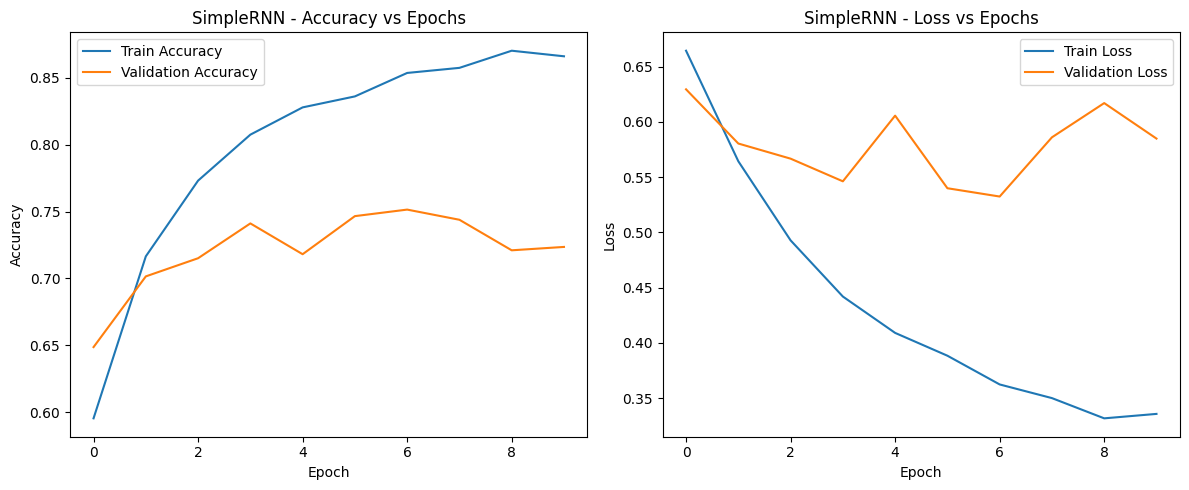

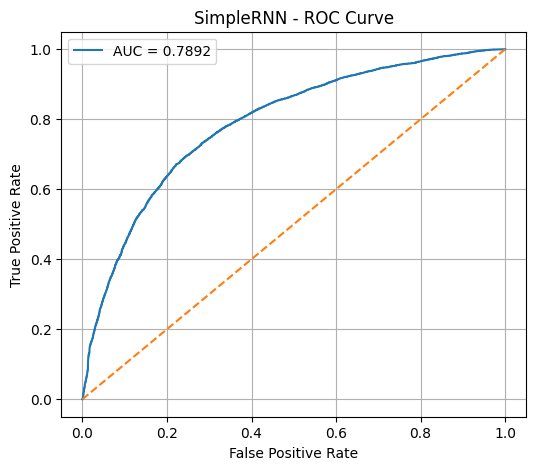

In [13]:
# MODEL 1: SIMPLE RNN
print("\nTraining SimpleRNN model...")
rnn_model = RNNModel(max_features, embedding_dims, hidden_dim=32, rnn_type='rnn')
optimizer = optim.RMSprop(rnn_model.parameters())
criterion = nn.BCELoss()

rnn_model, rnn_train_losses, rnn_train_accs, rnn_val_losses, rnn_val_accs, rnn_y_true, rnn_y_scores = train_model(
    rnn_model, train_loader, test_loader, optimizer, criterion, epochs, device
)

evaluate_and_plot("SimpleRNN", rnn_train_losses, rnn_train_accs, rnn_val_losses, rnn_val_accs, rnn_y_true, rnn_y_scores)


Training LSTM model...
Epoch 1/10 - Train Loss: 0.5922, Train Acc: 0.6703, Val Loss: 0.4665, Val Acc: 0.7859, Time: 3.07s
Epoch 2/10 - Train Loss: 0.4242, Train Acc: 0.8182, Val Loss: 0.4263, Val Acc: 0.8156, Time: 2.25s
Epoch 3/10 - Train Loss: 0.3214, Train Acc: 0.8730, Val Loss: 0.4222, Val Acc: 0.8224, Time: 2.18s
Epoch 4/10 - Train Loss: 0.2687, Train Acc: 0.8989, Val Loss: 0.4143, Val Acc: 0.8275, Time: 2.36s
Epoch 5/10 - Train Loss: 0.2323, Train Acc: 0.9155, Val Loss: 0.4596, Val Acc: 0.8202, Time: 2.17s
Epoch 6/10 - Train Loss: 0.1984, Train Acc: 0.9309, Val Loss: 0.4419, Val Acc: 0.8356, Time: 2.18s
Epoch 7/10 - Train Loss: 0.1721, Train Acc: 0.9397, Val Loss: 0.4750, Val Acc: 0.8270, Time: 2.18s
Early stopping triggered after epoch 7

Final Evaluation on Test Set (LSTM):
Accuracy : 0.8270
Precision: 0.8471
Recall   : 0.7980
F1 Score : 0.8218
AUC      : 0.9000


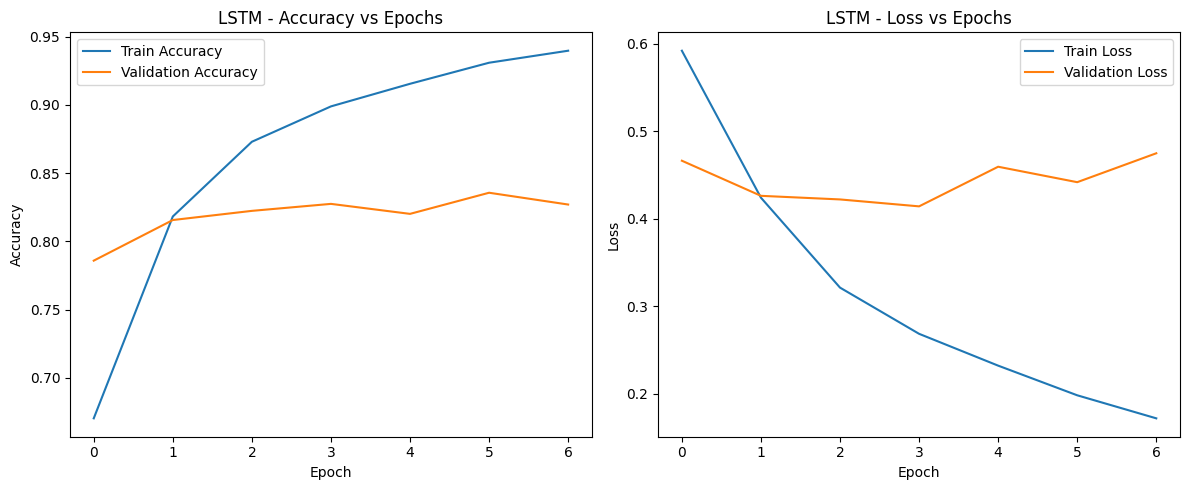

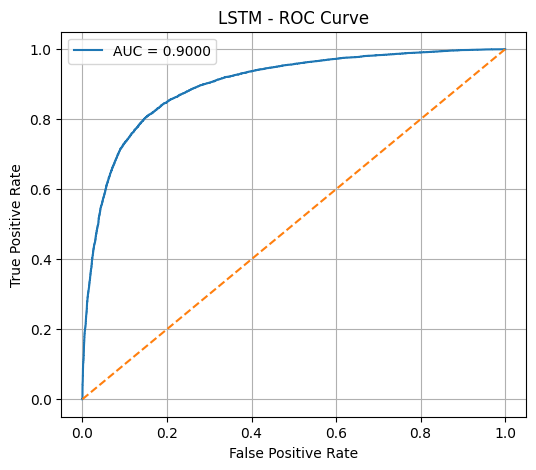

In [14]:
# MODEL 2: LSTM
print("\nTraining LSTM model...")
lstm_model = RNNModel(max_features, embedding_dims, hidden_dim=32, rnn_type='lstm')
optimizer = optim.RMSprop(lstm_model.parameters())
criterion = nn.BCELoss()

lstm_model, lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs, lstm_y_true, lstm_y_scores = train_model(
    lstm_model, train_loader, test_loader, optimizer, criterion, epochs, device
)

evaluate_and_plot("LSTM", lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs, lstm_y_true, lstm_y_scores)


Training GRU model...
Epoch 1/10 - Train Loss: 0.5953, Train Acc: 0.6737, Val Loss: 0.4957, Val Acc: 0.7758, Time: 2.40s
Epoch 2/10 - Train Loss: 0.4373, Train Acc: 0.8073, Val Loss: 0.4904, Val Acc: 0.7656, Time: 2.25s
Epoch 3/10 - Train Loss: 0.3563, Train Acc: 0.8535, Val Loss: 0.4566, Val Acc: 0.7917, Time: 2.24s
Epoch 4/10 - Train Loss: 0.3122, Train Acc: 0.8785, Val Loss: 0.4787, Val Acc: 0.8005, Time: 2.25s
Epoch 5/10 - Train Loss: 0.3118, Train Acc: 0.8764, Val Loss: 0.4767, Val Acc: 0.7946, Time: 2.35s
Epoch 6/10 - Train Loss: 0.2620, Train Acc: 0.8997, Val Loss: 0.4899, Val Acc: 0.7964, Time: 2.36s
Early stopping triggered after epoch 6

Final Evaluation on Test Set (GRU):
Accuracy : 0.7964
Precision: 0.7769
Recall   : 0.8315
F1 Score : 0.8033
AUC      : 0.8721


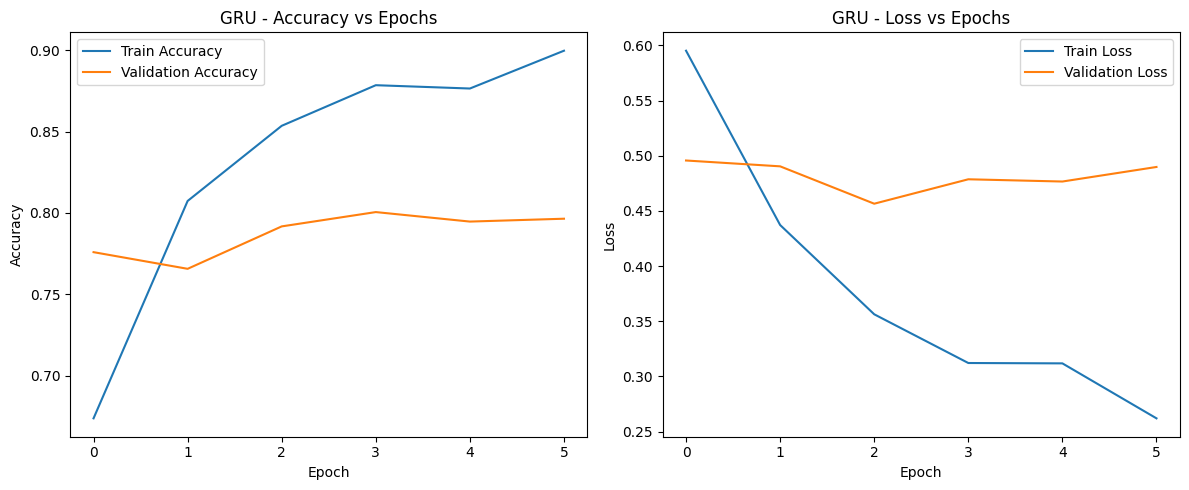

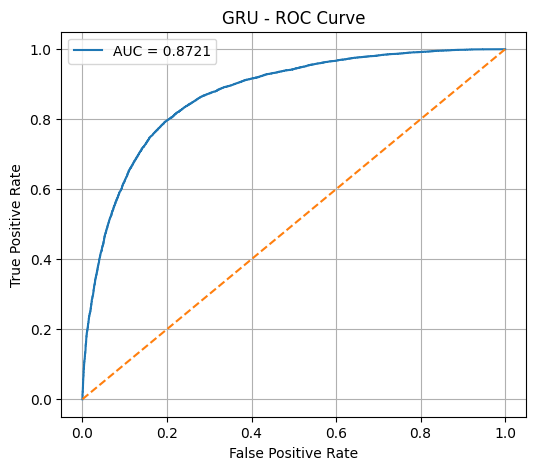

In [15]:
# MODEL 3: GRU
print("\nTraining GRU model...")
gru_model = RNNModel(max_features, embedding_dims, hidden_dim=32, rnn_type='gru')
optimizer = optim.RMSprop(gru_model.parameters())
criterion = nn.BCELoss()

gru_model, gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs, gru_y_true, gru_y_scores = train_model(
    gru_model, train_loader, test_loader, optimizer, criterion, epochs, device
)

evaluate_and_plot("GRU", gru_train_losses, gru_train_accs, gru_val_losses, gru_val_accs, gru_y_true, gru_y_scores)